# Lab: Batch Normalization and Transfer Learning



------------------------------------------------------
*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------

Batch normalization was introduced in Sergey Ioffe's and Christian Szegedy's 2015 paper [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf). The idea is that, instead of just normalizing the inputs to the network, we normalize the inputs to _layers within_ the network. 

> It's called **batch** normalization because during training, we normalize each layer's inputs by using the mean and variance of the values in the current *batch*.

We will first analyze the effect of Batch Normalization (BN) in a simple NN with dense layers. Then you will be able to incorportate BN into the CNN that you designed in the first part of CNNs Lab. 

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

PRÁCTICA 3 PARTE 2 - REDES NEURONALES - MASTER EN INTELIGENCIA ARTIFICIAL APLICADA

JOSÉ LORENTE LÓPEZ - DNI: 48842308Z

JAVIER ROMERO GARCÍA - DNI: 49276810T

A lo largo de esta práctica estudiaremos el efecto del batch normalization en el rendimiento de nuestro modelo. Como sabemos, el internal covariate shift nace del hecho de que las distribuciones de los datos a las entradas de las capas cambia en cada paso del entrenamiento (lo cual es lógico ya que los pesos van cambiando). Esto afecta al rendimiento y rapidez del entrenamiento del modelo por lo que aplicamos este "batch normalization". Esta ténica consiste en (aparte de la normalización de los datos que entran a la red) normalizar las entradas a las capas; para esto, a la salida de cada capa, normalizamos la salida de cada neurona usando la media y la std del batch que ha entrado a dicha neurona. De esta manera, las distribuciones se quedan más o menos parecidas en cada iteración del entrenamiento. Lo probaremos con un MLP sencillo y luego con la CNN de la primera parte.

## Batch Normalization in PyTorch<a id="implementation_1"></a>

This section of the notebook shows you one way to add batch normalization to a neural network built in PyTorch. 

The following cells import the packages we need in the notebook and load the MNIST dataset to use in our experiments.

Veamos como introducir batch normalization a nuestras redes neuronales creadas con PyTorch

In [1]:
# Importamos las librerías necesarias para el desarrollo de la práctica

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

d:\anaconda\envs\ids\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Importamos el conjunto de entrenamiento y testeo del dataset MNIST

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

### Neural network classes

The following class, `MLP`, allows us to create identical neural networks **with and without batch normalization** to compare. We are defining a simple NN with **two dense layers** for classification; this design choice was made to support the discussion related to batch normalization and not to get the best classification accuracy.

Two importants points about BN:

- We use PyTorch's [BatchNorm1d](https://pytorch.org/docs/stable/nn.html#batchnorm1d). This is the function you use to operate on linear layer outputs; you'll use [BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d) for 2D outputs like filtered images from convolutional layers. 
- We add the batch normalization layer **before** calling the activation function.


Este MLP permite crear la misma red con y sin batch normalization. Es una red muy simple que creamos para discutir el batch normalization, no para obtener buenos resultados de accuracy en clasificación.

Usamos BatchNorm1d para operar sobre capas lineales (de MLP) sin embargo, sobre capas convoluciones (donde contamos con datos en 2D (imágenes -> alturaxanchura)) se usa BatchNorm2d
El batch normalization va después de la función lineal de la capa pero antes de la función no lineal. Es decir, a la salidas de las neuronas pero antes de las funciones de activación.

In [3]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels,use_batch_norm): #Nlabels will be 10 in our case # use_batch_norm será True si queremos usarlo y False en caso contrario
        
        super().__init__()
        
        # Keep track of whether or not this network uses batch normalization.
        self.use_batch_norm = use_batch_norm
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)        
        
        self.output3 = nn.Linear(hidden2,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        if self.use_batch_norm: # si hemos puesto true porque queremos usar el batch normalization, aplica dicho efecto sobre las dos capas ocultas

            self.batch_norm1 = nn.BatchNorm1d(hidden1)
            
            self.batch_norm2 = nn.BatchNorm1d(hidden2)
            
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.output2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)        
        x = self.relu(x)
        x = self.output3(x)
        x = self.logsoftmax(x) 
        return x

> **Exercise:** 
> 
> - Create a validation set with the 20% of training set
> - Extend the class above to incorporate a training method where both training and validation losses are computed, and a method to evaluate the classification performance on a given set

**Note:** As we do with Dropout, for BN we have to call the methods `self.eval()` and `self.train()` in both validation and training. Setting a model to evaluation mode is important for models with batch normalization layers!

>* Training mode means that the batch normalization layers will use **batch** statistics to calculate the batch norm. 
* Evaluation mode, on the other hand, uses the estimated **population** mean and variance from the entire training set, which should give us increased performance on this test data!  

In [4]:
# Veamos la cantidad de imágenes en el conjunto de entrenamiento con el fin de poder distribuir correctamente con el conjunto de validación.
len(trainloader.dataset) 

60000

In [5]:
# YOUR CODE HERE
import copy


validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

# Guardamos un 80% del entrenamiento al entrenamiento final (de 60k, el 80% corresponde a 48k imágenes)
trainloader.dataset.data = trainloader.dataset.data[:48000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:48000]

# El 20% restante se deja para validación (aprox 12k imágenes)
validloader.dataset.data = validloader.dataset.data[48032:,:,:]
validloader.dataset.targets = validloader.dataset.targets[48032:]

Tomo en validación desde la imagen 48032 y no desde la 48000 por el siguiente motivo: El problema es que si tomo de 48000 hasta 60000 lo que tengo son 187,5 batches por lo que se quedan 32 imágenes sueltas y el programa suelta un error, es por ello que tomo desde 48032 para tener 187 batches exactos. 

In [6]:
# Comprobemos si la distribución (train -> 48k imágenes & validation -> aprox 12k imágenes) se ha realizado correctamente

print('Contamos con ' + str(len(trainloader.dataset)) + ' imágenes en el conjunto de entrenamiento')
print('Contamos con ' + str(len(validloader.dataset)) + ' imágenes en el conjunto de validación')

Contamos con 48000 imágenes en el conjunto de entrenamiento
Contamos con 11968 imágenes en el conjunto de validación


In [9]:
#YOUR CODE HERE

class MLP_extended(MLP):
 
    def __init__(self,dimx,hidden1,hidden2,nlabels,use_batch_norm,epochs=100,lr=0.001): # simplemente introducimos la capacidad de activar o desactivar el batch normalization
        
        super().__init__(dimx,hidden1,hidden2,nlabels,use_batch_norm)  #To initialize `MLP`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()              
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 

        # Lista que guarda la evolución de la función de coste en validación a lo largo del entrenamiento

        self.valid_loss_during_training = [] 
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            validation_loss = 0
            running_loss_val = 0

            self.train() # ya que vamos a entrenar el modelo y queremos aplicar dropout

            for images, labels in trainloader:             
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1)) # en todos los forward de aquí obviamos el flatten ya que se hace dentro del propio forward 

                #Your code here (multiple lines)
                
                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()

            with torch.no_grad(): # de esta forma ahorra en coste computacional

                self.eval() # desactivamos el droput para el test del conjunto de evaluación
               
                running_loss_val = 0

                for images, labels in validloader:

                    out = self.forward(images.view(images.shape[0], -1))
                    loss = self.criterion(out, labels)
                    running_loss_val += loss.item()
                # de esta forma, en cada época, estudiamos el valor de la función de coste sobre todo el conjunto de validación
                
            self.loss_during_training.append(running_loss/len(trainloader))
            self.valid_loss_during_training.append(running_loss_val/len(validloader)) # actualizamos dicho valor en la época correspondiente

            if(e % 1 == 0): # Every 1 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
                print("Validation loss after %d epochs: %f" 
                      %(e,self.valid_loss_during_training[-1])) # ploteamos el valor de la función de coste sobre el conjunto de valdación en cada época
                print('')

    def acurracy_study(self,loader,modelo):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            
            self.eval()
            for images,labels in loader:
        
                logprobs = modelo.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities
        
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        #print("Test Accuracy %f" %(accuracy/len(loader)))

        return ((accuracy/len(loader)).numpy().max())

### Create two different models for testing

* `net_batchnorm` uses batch normalization applied to the output of its hidden layers
* `net_no_norm` does not use batch normalization

Besides the normalization layers, everthing about these models is the same.

> **Exercise:** Train both models and compare the evolution of the train/validation loss in both cases

In [10]:
# Creamos el MLP con batch normalization

net_batchnorm = MLP_extended(dimx=784, hidden1=128, hidden2=64, nlabels=10, use_batch_norm = True , epochs=10, lr=1e-3)
net_batchnorm.trainloop(trainloader,validloader)

Training loss after 0 epochs: 0.284791
Validation loss after 0 epochs: 0.130524

Training loss after 1 epochs: 0.103229
Validation loss after 1 epochs: 0.093973

Training loss after 2 epochs: 0.072518
Validation loss after 2 epochs: 0.094782

Training loss after 3 epochs: 0.054349
Validation loss after 3 epochs: 0.092092

Training loss after 4 epochs: 0.044696
Validation loss after 4 epochs: 0.086883

Training loss after 5 epochs: 0.037925
Validation loss after 5 epochs: 0.079313

Training loss after 6 epochs: 0.032277
Validation loss after 6 epochs: 0.078860

Training loss after 7 epochs: 0.026144
Validation loss after 7 epochs: 0.084299

Training loss after 8 epochs: 0.025692
Validation loss after 8 epochs: 0.085143

Training loss after 9 epochs: 0.021828
Validation loss after 9 epochs: 0.084763



In [11]:
# Creamos el MLP sin batch normalization

net_no_norm = MLP_extended(dimx=784, hidden1=128, hidden2=64, nlabels=10, use_batch_norm = False , epochs=10, lr=1e-3)
net_no_norm.trainloop(trainloader,validloader)

Training loss after 0 epochs: 0.438436
Validation loss after 0 epochs: 0.249398

Training loss after 1 epochs: 0.222555
Validation loss after 1 epochs: 0.182210

Training loss after 2 epochs: 0.156534
Validation loss after 2 epochs: 0.135696

Training loss after 3 epochs: 0.124933
Validation loss after 3 epochs: 0.116805

Training loss after 4 epochs: 0.105617
Validation loss after 4 epochs: 0.119738

Training loss after 5 epochs: 0.089893
Validation loss after 5 epochs: 0.112102

Training loss after 6 epochs: 0.082163
Validation loss after 6 epochs: 0.124856

Training loss after 7 epochs: 0.071019
Validation loss after 7 epochs: 0.106572

Training loss after 8 epochs: 0.065834
Validation loss after 8 epochs: 0.104306

Training loss after 9 epochs: 0.058344
Validation loss after 9 epochs: 0.117405



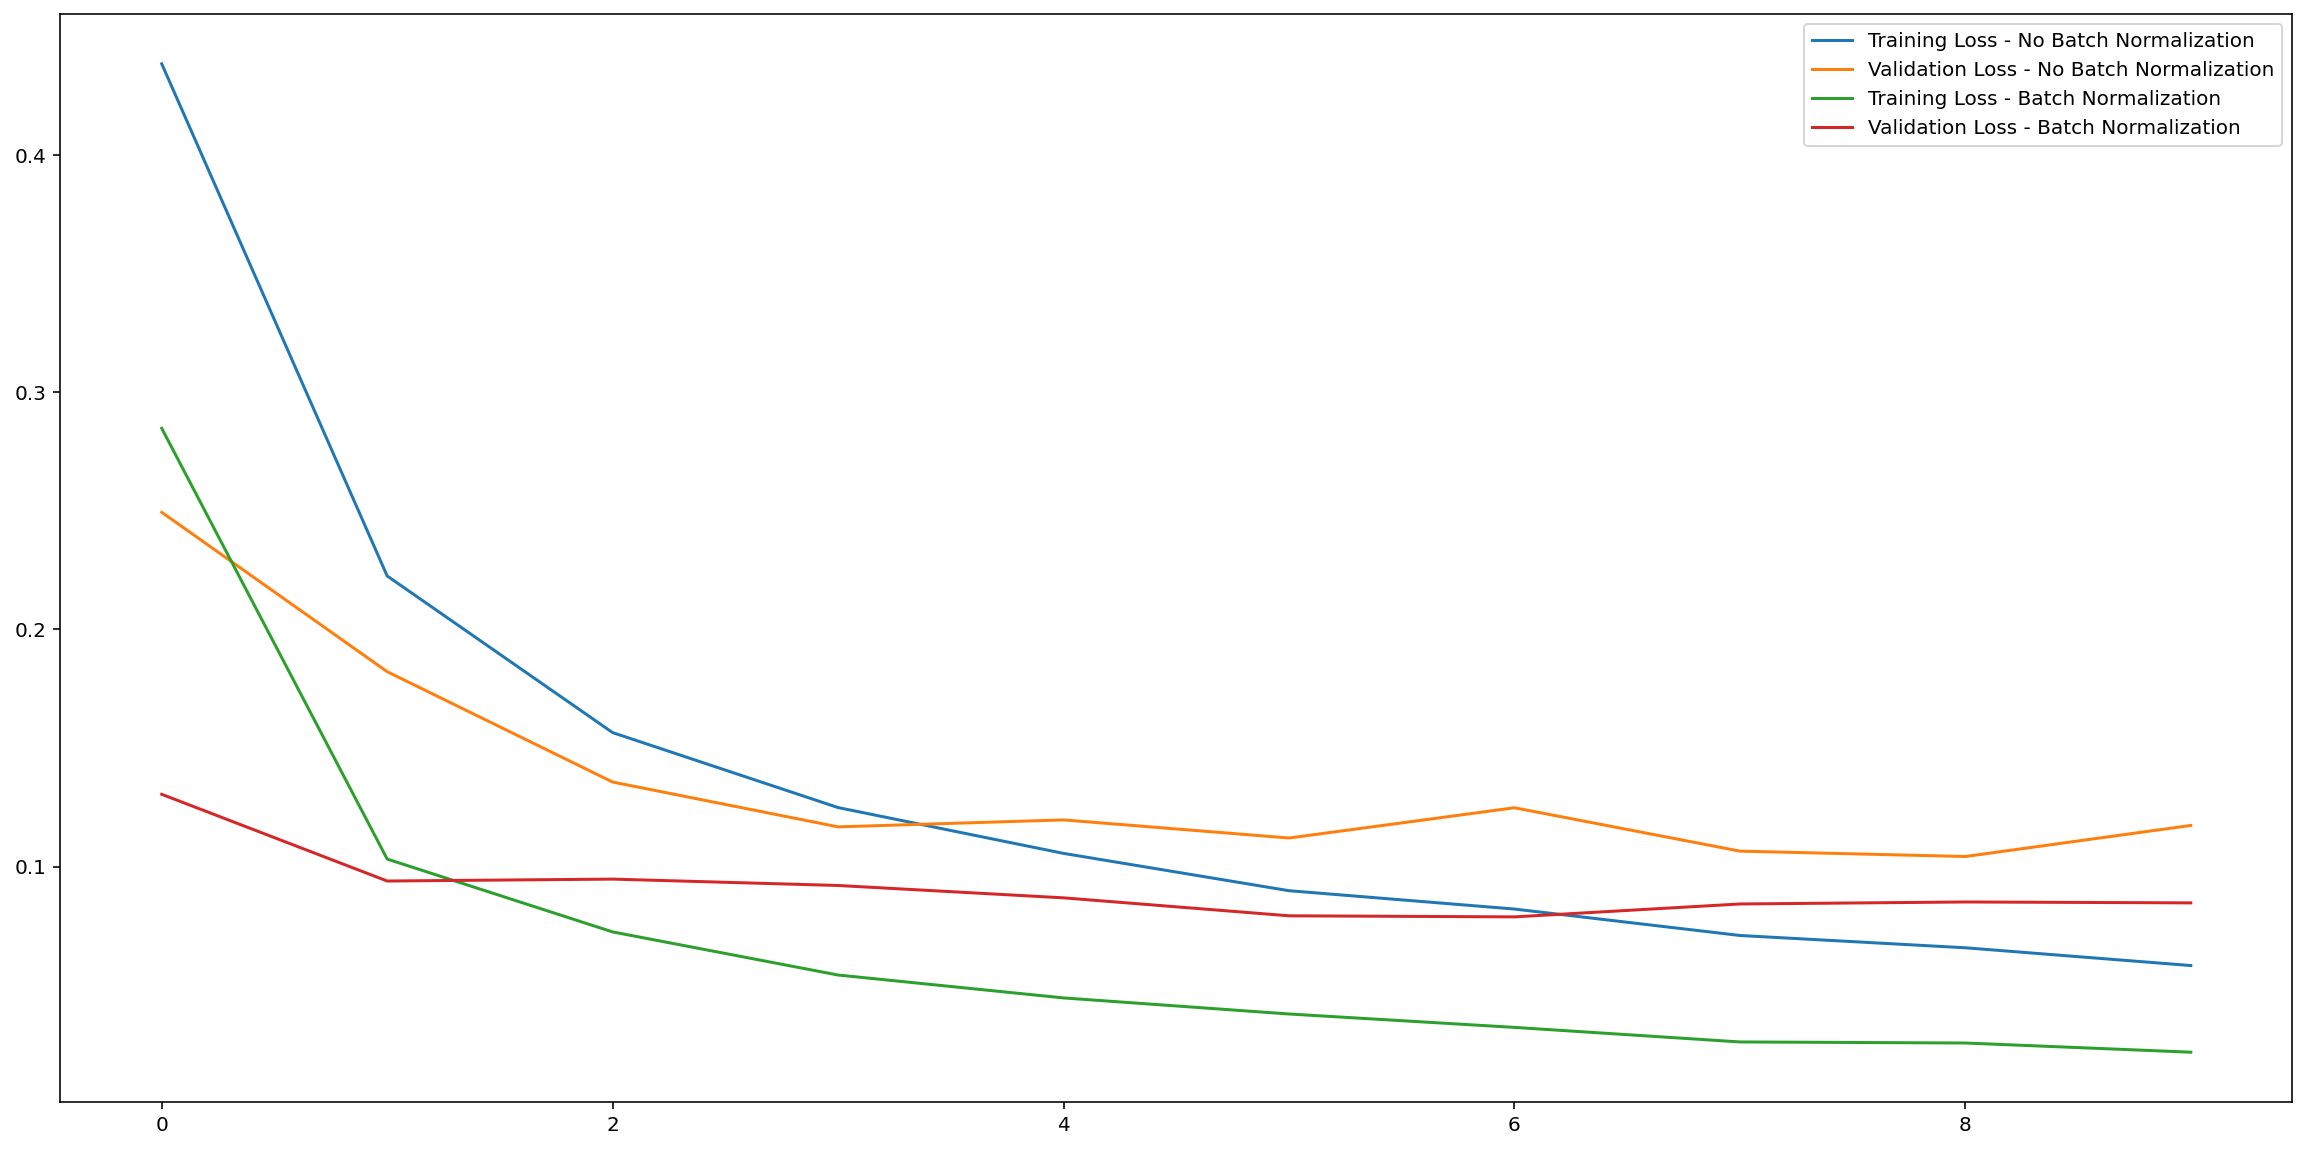

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(net_no_norm.loss_during_training,label='Training Loss - No Batch Normalization')
ax.plot(net_no_norm.valid_loss_during_training,label='Validation Loss - No Batch Normalization')
ax.plot(net_batchnorm.loss_during_training,label='Training Loss - Batch Normalization')
ax.plot(net_batchnorm.valid_loss_during_training,label='Validation Loss - Batch Normalization')
ax.legend()
fig.set_facecolor('white')

Los resultados cuadran con lo programado. Como vemos, las funciones de coste asociadas al MLP con batch normalization, en las mismas épocas, convergen más rápido que las del MLP que no cuenta con batch normalization (esto tiene sentido ya que combatimos el invariance shift el cual provoca una relentización del proceso de entrenamiento, provocando convergencia en un número mayor de épocas). Por otro lado, cabe destacar que el conjunto de validación (como se puede ver) sufre de overfitting (ya que, mientras las funciones de coste asociadas al conjunto de entrenamiento tanto con y sin batch normalization, siguen descendiendo, las de validación llega un punto que empiezan a aumentar, simbolo claro de sobre aprendizaje en el conjunto de train por parte del modelo).

---
### Considerations for other network types

This notebook demonstrates batch normalization in a standard neural network with fully connected layers. You can also use batch normalization in other types of networks, but there are some special considerations.

#### ConvNets

Convolution layers consist of multiple feature maps. (Remember, the depth of a convolutional layer refers to its number of feature maps.) And the weights for each feature map are shared across all the inputs that feed into the layer. Because of these differences, batch normalizing convolutional layers requires batch/population mean and variance per feature map rather than per node in the layer.

> To apply batch normalization on the outputs of convolutional layers, we use [BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d). To use it, we simply state the **number of input feature maps**. I.e. `nn.BatchNorm2d(num_features=nmaps)`


#### RNNs

Batch normalization can work with recurrent neural networks, too, as shown in the 2016 paper [Recurrent Batch Normalization](https://arxiv.org/abs/1603.09025). It's a bit more work to implement, but basically involves calculating the means and variances per time step instead of per layer. You can find an example where someone implemented recurrent batch normalization in PyTorch, in [this GitHub repo](https://github.com/jihunchoi/recurrent-batch-normalization-pytorch).

> **Exercise:** Using CIFAR10 database, incorporate BN to your solution of the previous lab on CNNs. Compare the results with and without BN!!

In [14]:
#YOUR CODE HERE

# Usaremos el database CIFAR10 para provar el efecto del batch normalization sobre la CNN de la práctica anterior

import torch
from torchvision import datasets, transforms, utils

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalizamos las tres dimensiones anchoxaltoxprofundidad

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [15]:
traindata = iter(trainloader)

images, labels = next(traindata)

print(images[1].shape)

torch.Size([3, 32, 32])


In [16]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize to pot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

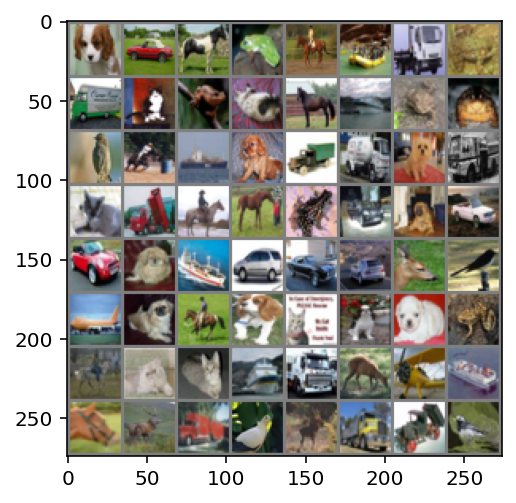

In [17]:
imshow(utils.make_grid(images)) # Con esta función primero desnormalizamos los píxeles de las imágenes (para que se vean bien al representarse)

In [18]:
# Primero veamos la cantidad de imágenes que tengo en mi conjunto de entrenamiento

len(trainloader.dataset) 

50000

In [19]:
# YOUR CODE HERE
import copy

# Pasamos un 20% de los datos de train a validación

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

# Guardamos un 80% del entrenamiento al entrenamiento final (de 50k, el 80% corresponde a 40k imágenes)
trainloader.dataset.data = trainloader.dataset.data[:40000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:40000]

# El 20% restante se deja para validación (10k imágenes)
validloader.dataset.data = validloader.dataset.data[40000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[40000:]

In [20]:
# Comprobemos si la distribución (train -> 40k imágenes & validation -> 10k imágenes) se ha realizado correctamente

print('Contamos con ' + str(len(trainloader.dataset)) + ' imágenes en el conjunto de entrenamiento')
print('Contamos con ' + str(len(validloader.dataset)) + ' imágenes en el conjunto de validación')

Contamos con 40000 imágenes en el conjunto de entrenamiento
Contamos con 10000 imágenes en el conjunto de validación


In [21]:
class Lenet5(nn.Module):
    def __init__(self,dimx,nlabels,use_batch_norm): #Nlabels will be 10 in our case
        super().__init__()

        self.use_batch_norm = use_batch_norm

        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, 
                               kernel_size=5, stride=1, padding=0) # stride es el salto del filtro y el padding es rellenar con 0 el borde
        
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)

        # Con esto hemos establecido las dos capas convolucionales (Convolución con kernel 5x5 en saltos de 1)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2) # Define el maxpooling 2x2 que vamos a aplicar a las salidas de las ReLu que tienen como entrada las salidas de las capas convolucionales

        # Linear layers

        # Las tres capas lineales MLP que van tras las convolucionales en forma de clasificador

        self.linear1 = nn.Linear(400,120) # A la entrada tenemos 400 de dimensión al contart con 16 mapas de 5x5 (16*5*5 = 400)
        
        self.linear2 = nn.Linear(120,84)
        
        self.linear3 = nn.Linear(84,nlabels) # nlabels = 10 (ya que tenemos 10 categorías/etiquetas diferentes)
    
        self.relu = nn.ReLU() # La activación tras capas convolucionales y hidden layers del MLP será ReLu para atenuar el desvanecimiento de gradiente.
        
        self.logsoftmax = nn.LogSoftmax(dim=1) # Se usa como activación a la salida del MLP para clasificación multiclase
        
        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)

        if self.use_batch_norm: # si hemos puesto true porque queremos usar el batch normalization, aplica dicho efecto sobre las dos capas ocultas

            self.batch_norm1 = nn.BatchNorm2d(num_features=6) # A las capas convolucionales les aplicado batchnorm2D introduciendole el número de feature maps a la salida de dicha capa
            
            self.batch_norm2 = nn.BatchNorm2d(num_features=16)

            self.batch_norm3 = nn.BatchNorm1d(120)
            
            self.batch_norm4 = nn.BatchNorm1d(84)
        
    def forward(self, x): # introducimos a la salida de cada capa (convolucional o lineal) la opción de aplicar a los datos de salida batch normalization (si el usuario lo desea) justo antes de introducir dichos datos en la función de activación 
        # Pass the input tensor through the CNN operations
        x = self.conv1(x)
        if self.use_batch_norm:
            x = self.batch_norm1(x) 
        x = self.relu(x) 
        x = self.pool(x)
        x = self.conv2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.pool(x)
        # Flatten the tensor into a vector of appropiate dimension using self.final_dim
        x = x.view(-1,400) # A la salida de la convolucional, hacemos un flatten de los datos a un vector de 400 píxeles y eso lo introducimos al MLP
        # Pass the tensor through the Dense Layers
        x = self.linear1(x)
        if self.use_batch_norm:
            x = self.batch_norm3(x)
        x = self.relu(x)
        x = self.linear2(x)
        if self.use_batch_norm:
            x = self.batch_norm4(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.logsoftmax(x) # a la salida para la clasificación multiclase
        return x

In [22]:
# Extendemos la clase incluyendo entrenamiento, estudio de la validación y del accuracy

class Lenet5_extended_GPU(Lenet5):
    
    #Your code here
    
    def __init__(self,dimx,nlabels,use_batch_norm,epochs=100,lr=0.001): # exactamente la misma clase extendiendo añadiendo el parámetro que permite usar o no el batch normalization
        
        super().__init__(dimx,nlabels,use_batch_norm)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Para implementar CUDA

        self.to(self.device) # Enviamos el modelo a la GPU
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            self.train()

            for images, labels in trainloader:
                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  # Enviamos los tensores a la GPU
        
                #Reset Gradients!
                self.optim.zero_grad()  #TO RESET GRADIENTS!
                
                #Get the output
                out = self.forward(images)

                #Compute the loss for the batch
                loss = self.criterion(out, labels)

                #Update the running loss
                running_loss += loss.item()
                
                #Compute gradients
                loss.backward()
                
                #Update network parameters
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():            
                
                running_loss = 0.
                
                self.eval()

                for images,labels in validloader:
                    
                    # Move input and label tensors to the default device
                    images, labels = images.to(self.device), labels.to(self.device)                     
                    
                    # Compute output for input minibatch
                    out = self.forward(images)

                    #Your code here
                    loss = self.criterion(out, labels)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    

            if(e % 1 == 0): # Every epoch

                print("Epoch %d. Training loss: %f, Validation loss: %f" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1]))
                
    def eval_performance(self,dataloader,modelo):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            self.eval()

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) # Enviamos los tensores a la GPU
                probs = modelo.forward(images) # We use a log-softmax, so what we get are log-probabilities

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return ((accuracy/len(dataloader)).numpy().max())

In [23]:
# Analizamos la CNN usando batch normalization

my_CNN_GPU_batch = Lenet5_extended_GPU(dimx=400,nlabels=10,use_batch_norm = True ,epochs=10,lr=1e-3)
my_CNN_GPU_batch.trainloop(trainloader,validloader)

Epoch 0. Training loss: 1.447879, Validation loss: 1.251993
Epoch 1. Training loss: 1.140895, Validation loss: 1.105975
Epoch 2. Training loss: 1.010393, Validation loss: 1.060261
Epoch 3. Training loss: 0.927254, Validation loss: 1.060413
Epoch 4. Training loss: 0.859503, Validation loss: 1.025043
Epoch 5. Training loss: 0.808839, Validation loss: 0.994461
Epoch 6. Training loss: 0.759331, Validation loss: 0.966078
Epoch 7. Training loss: 0.718882, Validation loss: 1.002283
Epoch 8. Training loss: 0.681298, Validation loss: 0.996148
Epoch 9. Training loss: 0.644756, Validation loss: 1.029999


In [25]:
# Analizamos la CNN sin usar batch normalization

my_CNN_GPU_nobatch = Lenet5_extended_GPU(dimx=400,nlabels=10,use_batch_norm = False ,epochs=10,lr=1e-3)
my_CNN_GPU_nobatch.trainloop(trainloader,validloader)

Epoch 0. Training loss: 1.678133, Validation loss: 1.484041
Epoch 1. Training loss: 1.405444, Validation loss: 1.362249
Epoch 2. Training loss: 1.287433, Validation loss: 1.269097
Epoch 3. Training loss: 1.197244, Validation loss: 1.213043
Epoch 4. Training loss: 1.129600, Validation loss: 1.181564
Epoch 5. Training loss: 1.069114, Validation loss: 1.145225
Epoch 6. Training loss: 1.018987, Validation loss: 1.115259
Epoch 7. Training loss: 0.977956, Validation loss: 1.099384
Epoch 8. Training loss: 0.940767, Validation loss: 1.101696
Epoch 9. Training loss: 0.903224, Validation loss: 1.109785


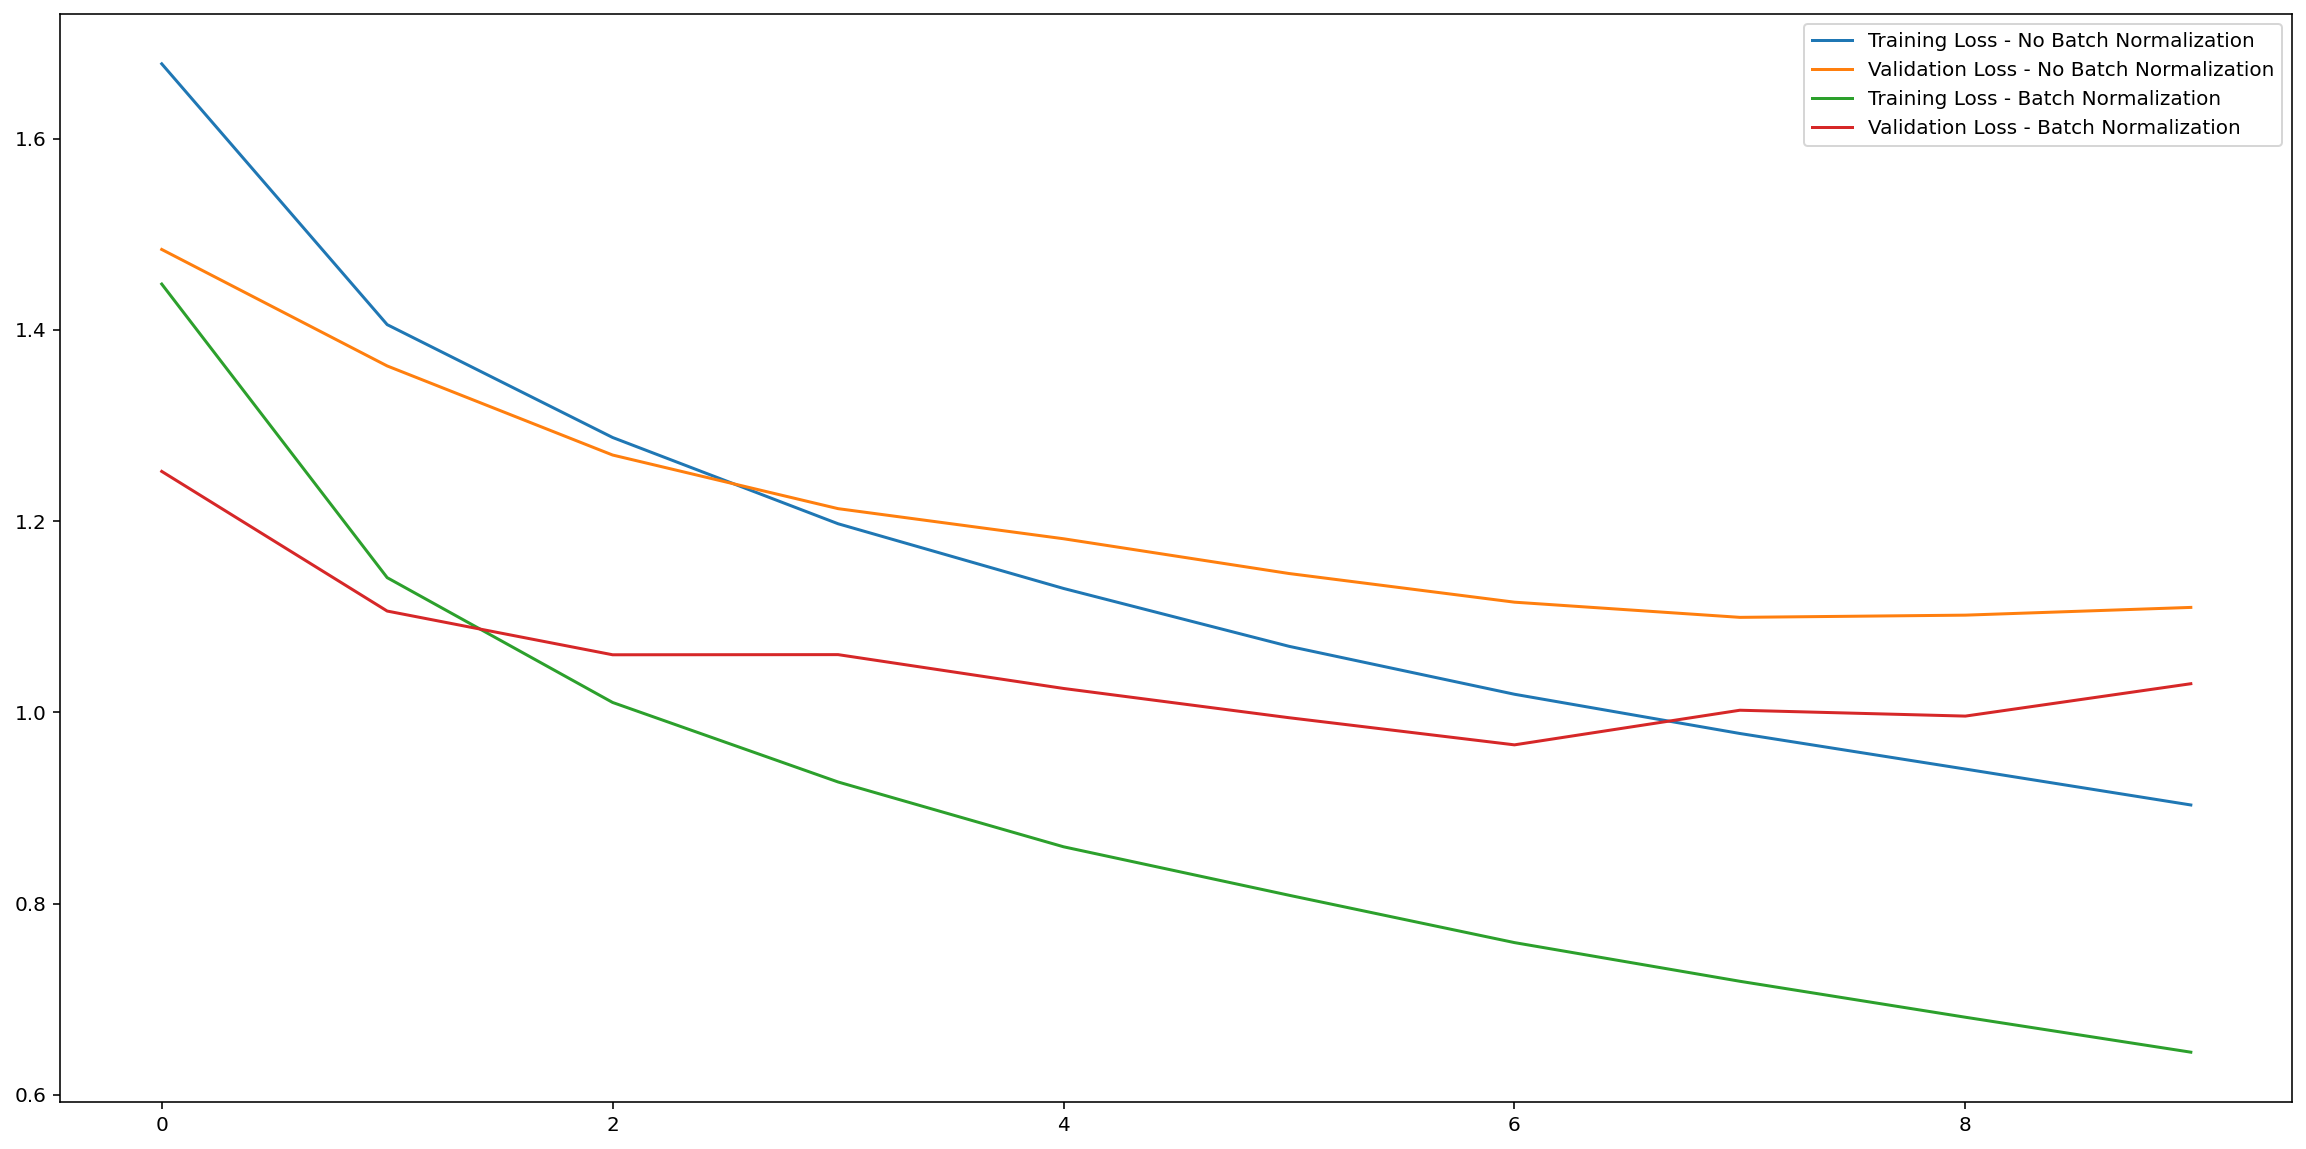

In [26]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(my_CNN_GPU_nobatch.loss_during_training,label='Training Loss - No Batch Normalization')
ax.plot(my_CNN_GPU_nobatch.valid_loss_during_training,label='Validation Loss - No Batch Normalization')
ax.plot(my_CNN_GPU_batch.loss_during_training,label='Training Loss - Batch Normalization')
ax.plot(my_CNN_GPU_batch.valid_loss_during_training,label='Validation Loss - Batch Normalization')
ax.legend()
fig.set_facecolor('white')

Ocurre muy parecido al efecto provocado en el MLP (lo cual tiene lógica). Como vemos, las funciones de coste asociadas a la CNN con batch normalization, en las mismas épocas, convergen más rápido que las de la CNN que no cuenta con batch normalization (de nuevo cuadra ya que combatimos el invariance shift el cual provoca una relentización del proceso de entrenamiento, provocando convergencia en un número mayor de épocas). Por otro lado, cabe destacar que el conjunto de validación (como se puede ver, de nuevo) sufre de overfitting (ya que, mientras las funciones de coste asociadas al conjunto de entrenamiento tanto con y sin batch normalization, siguen descendiendo, las de validación llega un punto que empiezan a aumentar, simbolo claro de sobre aprendizaje en el conjunto de train por parte del modelo).

## Transfer Learning in Pytorch

In this section of the lab, you'll learn how to use pre-trained CNN networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. 

Once trained over Imagenet, CNNs models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy. With [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

We'll be using a [dataset of cat and dog photos](https://www.kaggle.com/c/dogs-vs-cats) available from Kaggle. Here are a couple example images:

Utilizaremos una red pre-entrenada para estudiar clasificación de mis propias imágenes. Este concepto se llama transfer learning (donde obtenemos concimientos de los parámetros estudiados por la red pre-entrenada para la clasificación de nuestras propias imágenes). Usaremos este concepto para entrenar una red que pueda clasificar entre imágenes de perros y de gatos.

In [27]:
# Veamos algunas imágenes de nuestro dataset

from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://www.pyimagesearch.com/wp-content/uploads/2016/08/knn_kaggle_dogs_vs_cats_sample.jpg", width=400, height=200)


We'll use this dataset to train a neural network that can differentiate between cats and dogs. These days it doesn't seem like a big accomplishment, but five years ago it was a serious challenge for computer vision systems.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

In [28]:
# Implementemos las librerías necesarias para el transfer learning

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import time
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models

To run the notebook in Google Colab, we mount our Drive folder to later access the Cat & Dogs folder

In [29]:
# Dirección donde guardo el dataset de imágenes de perros y gatos

path_to_folder = 'C:/Users/José/Desktop/Master - CIII/1ºCuatrimestre/1ºSemicuatrimestre/Codigo-Python/Redes de Neuronas/Practica3'  # UPDATE THIS ACCORDING TO WHERE YOU HAVE SAVED THE DATABASE!

## Load the data set. Incorporate Data Augmentation

#### Dataset folder structure

The easiest way to load you own training/test image dataset is with `datasets.ImageFolder` from `torchvision` ([documentation](http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder)). In general you'll use `ImageFolder` like so:

```python
dataset = datasets.ImageFolder('path/to/data', transform=transform)
```

where `'path/to/data'` is the file path to the data directory and `transform` is a sequence of processing steps built with the [`transforms`](http://pytorch.org/docs/master/torchvision/transforms.html) module from `torchvision`. **More about this below**. ImageFolder expects the files and directories to be constructed like so:
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

where each class has it's own directory (`cat` and `dog`) for the images. The images are then labeled with the class taken from the directory name. So here, the image `123.png` would be loaded with the class label `cat`. 

You can check that the provided dataset has the required structure.

#### Data augmentation

A convolutional neural network that can robustly classify objects even if its placed in different orientations is said to have the property called invariance. More specifically, a CNN can be invariant to translation, viewpoint, size or illumination (Or a combination of the above). 

A common technique to enforce the invariancy of the CNN and obtain a more robust classifier is [Data Augmentation](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced), which seeks to train the neural network with additional synthetically modified data, generated by introducing randomness in the input data itself. For example, you can randomly rotate, mirror, scale, and/or crop your images during training. This will help your network generalize as it's seeing the same images but in different locations, with different sizes, in different orientations, etc. We do this by defining a torchvision `transform`, and you can learn about all the transforms that are used to pre-process and augment data, [here](https://pytorch.org/docs/stable/torchvision/transforms.html)

This type of data augmentation should add some positional variety to these images, so that when we train a model on this data, it will be robust in the face of geometric changes (i.e. it will recognize a ship, no matter which direction it is facing). It's recommended that you choose one or two transforms.


To randomly rotate, scale and crop, then flip your images you would define your transforms like this:

```python
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
```

You'll also typically want to normalize images with `transforms.Normalize`. You pass in a list of means and list of standard deviations, then the color channels are normalized like so

```input[channel] = (input[channel] - mean[channel]) / std[channel]```

Subtracting `mean` centers the data around zero and dividing by `std` squishes the values to be between -1 and 1. Normalizing helps keep the network weights near zero which in turn makes backpropagation more stable. Without normalization, networks will tend to fail to learn.

You can find a list of all [the available transforms here](http://pytorch.org/docs/0.3.0/torchvision/transforms.html). When you're testing however, you'll want to use images that aren't altered other than normalizing. So, for validation/test images, you'll typically just resize and crop.


In this notebook, we will use [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5) as feature extractor. It requires the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

With the following code, we load the dataset of cats & dogs, perform the data augmentation trasformations, and normalize the input images according to DenseNet.

Una CNN debe ser capaz de clasificar objetos incluso si están girados, con otro color o en otras posiciones. Para ello usaremos data augmentation el cual, a lo largo del entrenamiento, genera imágenes sintéticas a partir de las nuestras con variaciones como las que acabamos de comentar. Con esto creamos una red mucho más robusta capaz de clasificar independientemente de características de la imágen que no deben afectar.

In [30]:
data_dir = path_to_folder + '/Cat_Dog_data_reduced'

# Aplicamos el data augmentation en ambos conjuntos (entrenamiento y train)

# Train Set
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# Test Set
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

Lets visualize some images (they look weird because of the normalization)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


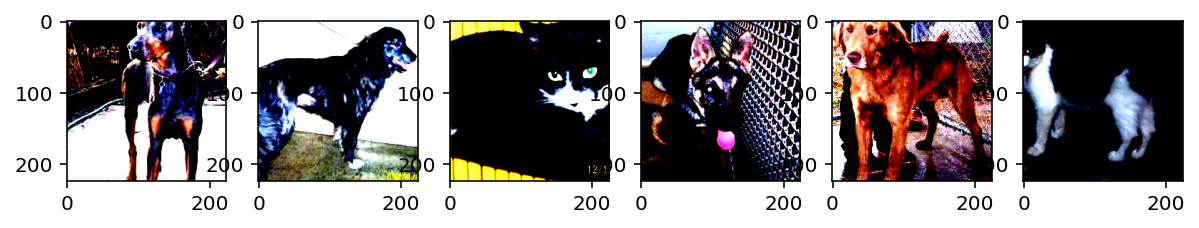

In [31]:
# Veamos algunas imágenes del dataset (se ven raras por la normalización)

data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=6)
for ii in range(6):
    ax = axes[ii]
    ax.imshow(images[ii,:,:,:].numpy().transpose((1,2,0)))

## Loading DenseNet and modifing the last classification layer


[DensetNet](https://arxiv.org/abs/1608.06993) was proposed in the 2017 IEEE Conference on Computer Vision and Pattern Recognition, and it is one of the most popular CNNs for computer vision applications. 

The models is huge and contains millions of parameters. [This excellent post](https://towardsdatascience.com/understanding-and-visualizing-densenets-7f688092391a) explains in detail the DenseNet structure. 

In [32]:
# Veamos como es la DenseNet (red pre-entrenada que usaremos). Este modelo cuenta con millones de parámetros.

Image(url= "https://miro.medium.com/max/1138/1*GeK21UAbk4lEnNHhW_dgQA.png", width=400, height=200)

In [33]:
Image(url= "https://miro.medium.com/max/2846/1*SsphOqMwglCVGDWB-jdT5Q.png", width=800, height=200)

We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [34]:
# Cargamos el modelo en una variable (lo cargamos preentrenado lógicamente para el transfer learning)

model = models.densenet121(pretrained=True)
model # veamos la arquitectura del modelo

d:\anaconda\envs\ids\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
d:\anaconda\envs\ids\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Aquí podemos analizar las características de cada capa de la red

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so **it won't work for our specific problem**. That means we need to replace the classifier, but the features will work perfectly on their own. In general, think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

Replacing the classifier is straightforward. We go step by step. 

> **Excercise:** Create a class for a NN binary classifier with two dense layers. Use 500 hidden units as the output dimension of the first layer.

Para poder adaptar la red a clasificar nuestras imágenes, debemos quitar lo que sería su clasificador (su MLP) e introducir uno nuestro.

Primero crearemos nuestro MLP

In [35]:
class MLP(nn.Module):
    def __init__(self,dimx=1024,hidden=500,nlabels=2): 
        
        super().__init__()
        
        self.output1 = nn.Linear(1024,500) # 1024 es la dimensión del vector flatten a la salida de la última capa convolucional de la DenseNet
    
        self.output2 = nn.Linear(500,2)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)                                                             
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        #YOUR CODE HERE 

        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.logsoftmax(x)
        return x

Now, we instantiate the class `MLP` we just created and replace the classifier part of DenseNet. Also, we freeze the rest of DenseNet parameters.

In [36]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

classifier = MLP(1024)
    
model.classifier = classifier # Cambiamos el clasificador del modelo por el nuestro

Una vez el modelo está creado y contamos con el transfer learning de la CNN pre-entrenada, debemos entre el clasificador-MLP a nuestro dataset de imágenes propio.

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

> **Exercise**: Complete the following code for a class that trains the defined model.

Note that, to make things easier, this time we pass the instatiated model as an input to the class!

You will see that training is slow (every epoch can take more than one hour). Hence, the following code is prepared to be trained for only a few minibatches (we specify the number of SGD iterations, not epochs). In any case, since the features learnt by Densenet are very discriminative, the classifier performs well within only a few iterations! Also, to save time we do not compute validation loss. But to do it right and evaluate overfitting, you should implement it!

El entrenamiento es muy lento por lo que en este caso solo entrenaremos unos pocos minibatches (ninguna época al completo). Con esto comprobaremos que funciona correctamente (lo que es la idea del transfer learning).

In [37]:
class Tran_Eval():
    
    
    def __init__(self,model,maxiter=500,lr=0.001):
        
        self.model = model
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.model.classifier.parameters(), self.lr)
        
        self.max_iter = maxiter
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model.to(self.device)
        
    def trainloop(self,trainloader):
        
        # Optimization Loop
        
        it_images = iter(trainloader)
        
        running_loss = 0.
        
        self.model.train()
        
        for e in range(int(self.max_iter)):

          
            images,labels = next(it_images)
            
            
            # Move input and label tensors to the default device
            images, labels = images.to(self.device), labels.to(self.device)  
        
            self.optim.zero_grad()  #TO RESET GRADIENTS!

            out = model.forward(images)

            loss = self.criterion(out, labels)

            running_loss = loss.item()

            #Your code here
            loss.backward()

            #Your code here
            self.optim.step()

            self.loss_during_training.append(running_loss)
            
            print('Batch %d of %d finished. Loss %f' %(e,self.max_iter,running_loss))            
        
                
    def eval_performance(self,dataloader,num_batches):

        accuracy = 0
        
        it_images = iter(dataloader)

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            self.model.eval()

            for e in range(int(num_batches)):
              
                print('Batch %d of %d' %(e,num_batches))
              
                images,labels = next(it_images)
                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) # Enviamos los tensores a la GPU
                probs = model.forward(images) # We use a log-softmax, so what we get are log-probabilities

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        return accuracy/num_batches

>**Exercise:** Train the model for 10 iterations. Compute the train/test performance in the first 5 batches of the datasets

In [42]:
#YOUR CODE HERE

# Entrenamos el clf-MLP de la DenseNet pre-entrenada con nuestro dataset de imágenes de perros y gatos
# Como el entrenamiento es lento, lo haremos solo durante 10 iteraciones del SGD (10 batches) 

my_densenet = Tran_Eval(model,maxiter=10,lr=0.001)
my_densenet.trainloop(trainloader)

Batch 0 of 10 finished. Loss 0.252819
Batch 1 of 10 finished. Loss 0.581208
Batch 2 of 10 finished. Loss 0.183767
Batch 3 of 10 finished. Loss 0.231293
Batch 4 of 10 finished. Loss 0.300883
Batch 5 of 10 finished. Loss 0.200091
Batch 6 of 10 finished. Loss 0.250274
Batch 7 of 10 finished. Loss 0.132095
Batch 8 of 10 finished. Loss 0.161423
Batch 9 of 10 finished. Loss 0.193241


Vemos como solo en 10 minibatches, la loss es muy buena. Esto ocurre porque los parámetros de la DenseNet son muy discriminativos. Comprobamos que hemos utilizado el modelo pre-entrenado correctamente usando nuestro propio clasificador MLP adapatado a nuestro dataset.

In [43]:
# Estudiemos el accuracy del modelo pre-entrenado usando nuestro propio clasificador MLP adapatado a nuestro dataset para el conjunto de entrenamiento y de test.

print('El accuracy de la red preentrenada junto a mi MLP clasificador sobre el conjunto de entrenamiento es: ' + str(my_densenet.eval_performance(trainloader,5)))
print('')
print('El accuracy de la red preentrenada junto a mi MLP clasificador sobre el conjunto de test es: ' + str(my_densenet.eval_performance(testloader,5)))

Batch 0 of 5
Batch 1 of 5
Batch 2 of 5
Batch 3 of 5
Batch 4 of 5
El accuracy de la red preentrenada junto a mi MLP clasificador sobre el conjunto de entrenamiento es: tensor(0.9250)

Batch 0 of 5
Batch 1 of 5
Batch 2 of 5
Batch 3 of 5
Batch 4 of 5
El accuracy de la red preentrenada junto a mi MLP clasificador sobre el conjunto de test es: tensor(0.9594)


Como vemos, solo con un entrenamiento de 20 minibatches (ni remotamente cerca de 1 sola época) el accuracy en ambos conjuntos (entrenamiento y test) supera el 90% llegando hasta 92,5% y 96% respectivamente. Es decir, no solo no contamos con nada de overfitting sino que tenemos una "performance" del modelo extremadamente buena en un tiempo muy rápido y óptimo.

Con esto, nos damos cuenta que hemos cogido una red preentrenada, no la hemos tenido que entrenar, la hemos usado para que nos haga un “resumen” de las imágenes sacando la parte más importante de la imagen funcionando como un “feature extractor” y luego al entrenar un MLP muy sencillo y con súper pocas iteraciones tenemos un modelo extremadamente bueno y con un accuracy altísimo.